# **Machine Learning Project**
## Neural Networks
For this project I will use a Convolutional Neural Netwrok, typically used for image detection and classification.

Here you can find explanations of some used functions
https://www.tensorflow.org/tutorials/images/cnn

# 1. Importing libraries

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
! pip install -q kaggle

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import keras_tuner as kt
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pickle

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# Set seed value
seed_value = 56
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)

# Set random seed for NumPy
np.random.seed(seed_value)

# Set random seed for TensorFlow
tf.random.set_seed(seed_value)

# 2. Load data

In [ ]:
from google.colab import files

files.upload() # upload your kaggle api key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michelamazzaglia","key":"f1045d0e8476daca75eb22afc5ac119a"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

 97% 460M/474M [00:06<00:00, 79.3MB/s]
100% 474M/474M [00:06<00:00, 78.4MB/s]


In [ ]:
!unzip -q ./muffin-vs-chihuahua-image-classification.zip -d .

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
# Define the paths to the train and test directories
train_dir = '/content/train'
test_dir = '/content/test'

# Define image dimensions and batch size
img_height, img_width = 100, 100
batch_size = 32
color_mode='rgb'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=56,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode= color_mode)

Found 4733 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=56,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False,
  color_mode= color_mode)

Found 1184 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['chihuahua', 'muffin']


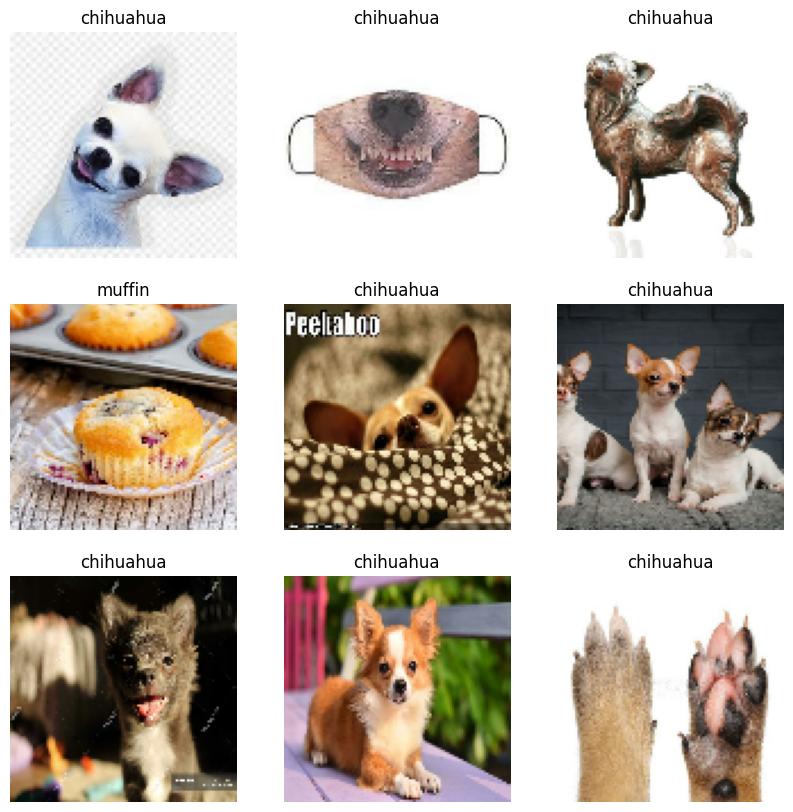

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = int(labels[i])
    plt.title(class_names[label_index])
    plt.axis('off')

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


## Loading functions

In [ ]:
from utilities import *

# 3. Data preprocessing

In [ ]:
train_images, train_labels = preprocess_train_dataset(train_ds)
test_images, test_labels = preprocess_test_dataset(test_ds)

In [ ]:
train_images.shape

(4733, 100, 100, 1)

In [ ]:
train_labels.shape

(4733,)

In [ ]:
test_images.shape

(1184, 100, 100, 1)

In [ ]:
test_labels.shape

(1184,)

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=56)

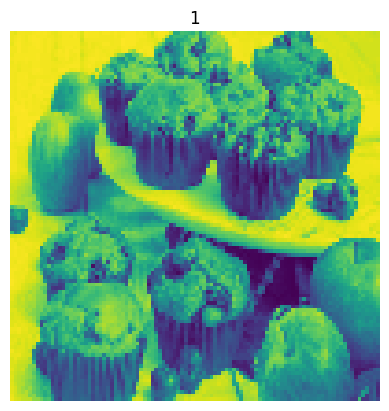

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
val_images = val_images / 255.0

# Display the scaled down and transformed image
plt.imshow(train_images[3])
plt.title(train_labels[3]) # 0 for chihuahua, 1 for muffin
plt.axis('off')
plt.show()

In [ ]:
print(np.min(train_images[3]), np.max(train_images[3]))

0.05842015 0.9971401


## Basic Model

We build a sequential model and add convolutional layers and max pooling layers to it.

### Training of the Basic Model

In [ ]:
with tf.device(device_name):
  model = basic_model()
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 32)       

In [ ]:
history = model.fit(train_images, train_labels, batch_size = batch_size, epochs=25, validation_data = (val_images, val_labels))

Epoch 1/25
119/119 [==============================] - 7s 21ms/step - loss: 0.6185 - accuracy: 0.6450 - val_loss: 0.5468 - val_accuracy: 0.7307
Epoch 2/25
119/119 [==============================] - 2s 15ms/step - loss: 0.4894 - accuracy: 0.7731 - val_loss: 0.4629 - val_accuracy: 0.7983
Epoch 3/25
119/119 [==============================] - 2s 16ms/step - loss: 0.4606 - accuracy: 0.7924 - val_loss: 0.4508 - val_accuracy: 0.7973
Epoch 4/25
119/119 [==============================] - 2s 18ms/step - loss: 0.3871 - accuracy: 0.8262 - val_loss: 0.5393 - val_accuracy: 0.7719
Epoch 5/25
119/119 [==============================] - 2s 16ms/step - loss: 0.3623 - accuracy: 0.8442 - val_loss: 0.3837 - val_accuracy: 0.8289
Epoch 6/25
119/119 [==============================] - 2s 14ms/step - loss: 0.3104 - accuracy: 0.8706 - val_loss: 0.3602 - val_accuracy: 0.8374
Epoch 7/25
119/119 [==============================] - 2s 14ms/step - loss: 0.2639 - accuracy: 0.8891 - val_loss: 0.4551 - val_accuracy: 0.8120

As we can see here the loss is very small which indicates that there is overfitting.

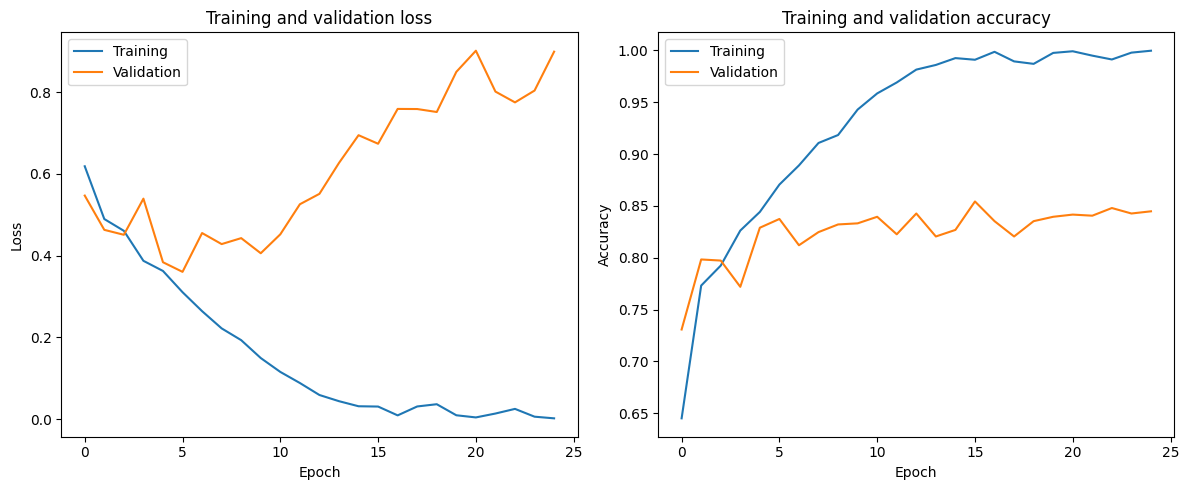

In [ ]:
performance(history)

Let us experiment with different architectural changes: adding or removing layers. Firstly we try to remove a layer and see how the model behaves.

In [ ]:
with tf.device(device_name):
  model1 = basic_model(remove_layer=True)
  model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 10, 10, 32)       

In [ ]:
history_1 = model1.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 3s 16ms/step - loss: 0.6181 - accuracy: 0.6503 - val_loss: 0.5326 - val_accuracy: 0.7423
Epoch 2/30
119/119 [==============================] - 2s 14ms/step - loss: 0.4958 - accuracy: 0.7726 - val_loss: 0.4691 - val_accuracy: 0.7846
Epoch 3/30
119/119 [==============================] - 2s 14ms/step - loss: 0.4590 - accuracy: 0.7929 - val_loss: 0.4452 - val_accuracy: 0.7983
Epoch 4/30
119/119 [==============================] - 2s 15ms/step - loss: 0.4018 - accuracy: 0.8214 - val_loss: 0.4871 - val_accuracy: 0.8004
Epoch 5/30
119/119 [==============================] - 2s 17ms/step - loss: 0.3789 - accuracy: 0.8349 - val_loss: 0.3950 - val_accuracy: 0.8226
Epoch 6/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3393 - accuracy: 0.8500 - val_loss: 0.3774 - val_accuracy: 0.8437
Epoch 7/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3132 - accuracy: 0.8658 - val_loss: 0.4549 - val_accuracy: 0.8089

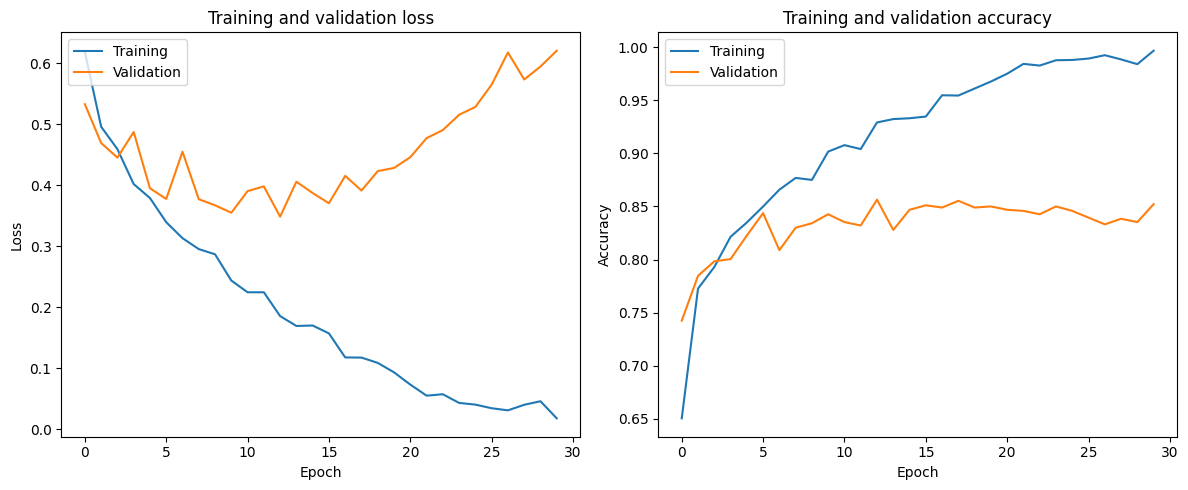

In [ ]:
performance(history_1)

Comparing with the previous output, we observe that although the training accuracy is slightly lower, the validation accuracy has improved. This indicates that removing the dense layer may have helped to reduce overfitting, as the model is now performing better on unseen validation data. However, further analysis and experimentation might be needed to optimize the model's architecture and hyperparameters for better performance.

Let us try to fix this by adding a Dropout layer.

In [ ]:
with tf.device(device_name):
  model2 = drop_model(dropout_rate = 0.5)
  model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 10, 10, 32)       

In [ ]:
history_2 = model2.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 5s 17ms/step - loss: 0.6089 - accuracy: 0.6643 - val_loss: 0.5057 - val_accuracy: 0.7455
Epoch 2/30
119/119 [==============================] - 2s 17ms/step - loss: 0.4723 - accuracy: 0.7842 - val_loss: 0.4345 - val_accuracy: 0.8078
Epoch 3/30
119/119 [==============================] - 2s 16ms/step - loss: 0.4465 - accuracy: 0.7993 - val_loss: 0.4146 - val_accuracy: 0.8131
Epoch 4/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3888 - accuracy: 0.8259 - val_loss: 0.3996 - val_accuracy: 0.8163
Epoch 5/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3500 - accuracy: 0.8518 - val_loss: 0.3827 - val_accuracy: 0.8310
Epoch 6/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3021 - accuracy: 0.8666 - val_loss: 0.3487 - val_accuracy: 0.8522
Epoch 7/30
119/119 [==============================] - 2s 15ms/step - loss: 0.2682 - accuracy: 0.8872 - val_loss: 0.3444 - val_accuracy: 0.8543

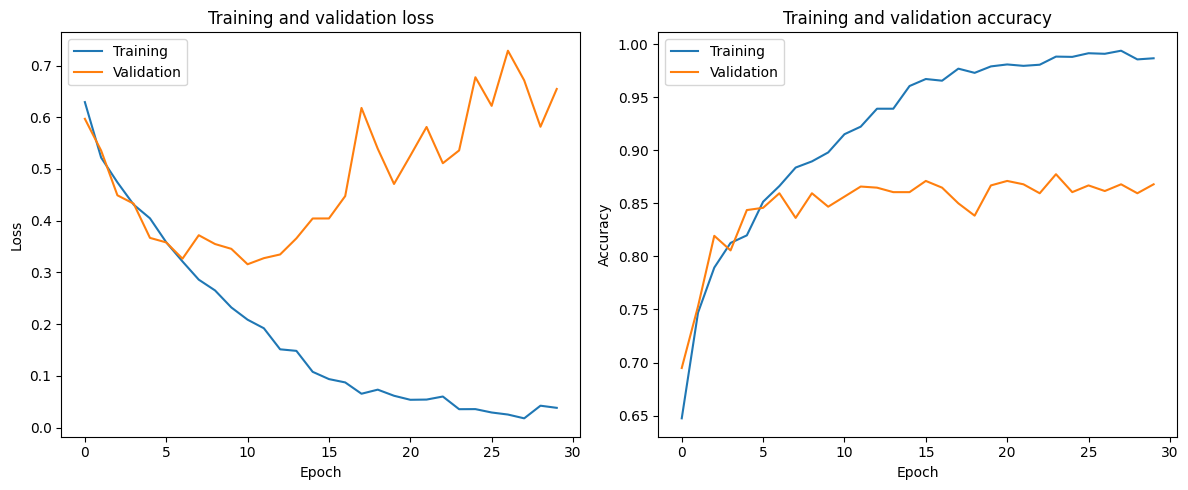

In [ ]:
performance(history_2)

Adding a dropout layer to the model appears to have led to a decrease in training accuracy compared to the previous outputs, indicating that the model is now less prone to overfitting. However, the validation accuracy has also decreased slightly, suggesting that there might still be room for improvement in the model's generalization performance.

Let us increase the dropout probability.

In [ ]:
model3 = Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.7),  # Dropout layer with dropout rate of 0.7
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
with tf.device(device_name):
  model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model3.summary()

In [ ]:
history_3 = model3.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 11s 21ms/step - loss: 0.6920 - accuracy: 0.5317 - val_loss: 0.6837 - val_accuracy: 0.5554
Epoch 2/30
119/119 [==============================] - 2s 15ms/step - loss: 0.6611 - accuracy: 0.5824 - val_loss: 0.5521 - val_accuracy: 0.7318
Epoch 3/30
119/119 [==============================] - 2s 17ms/step - loss: 0.5384 - accuracy: 0.7509 - val_loss: 0.4383 - val_accuracy: 0.8163
Epoch 4/30
119/119 [==============================] - 2s 16ms/step - loss: 0.4684 - accuracy: 0.8053 - val_loss: 0.3811 - val_accuracy: 0.8173
Epoch 5/30
119/119 [==============================] - 2s 14ms/step - loss: 0.4100 - accuracy: 0.8275 - val_loss: 0.3683 - val_accuracy: 0.8310
Epoch 6/30
119/119 [==============================] - 2s 14ms/step - loss: 0.3787 - accuracy: 0.8442 - val_loss: 0.3652 - val_accuracy: 0.8268
Epoch 7/30
119/119 [==============================] - 2s 15ms/step - loss: 0.3641 - accuracy: 0.8484 - val_loss: 0.3506 - val_accuracy: 0.832

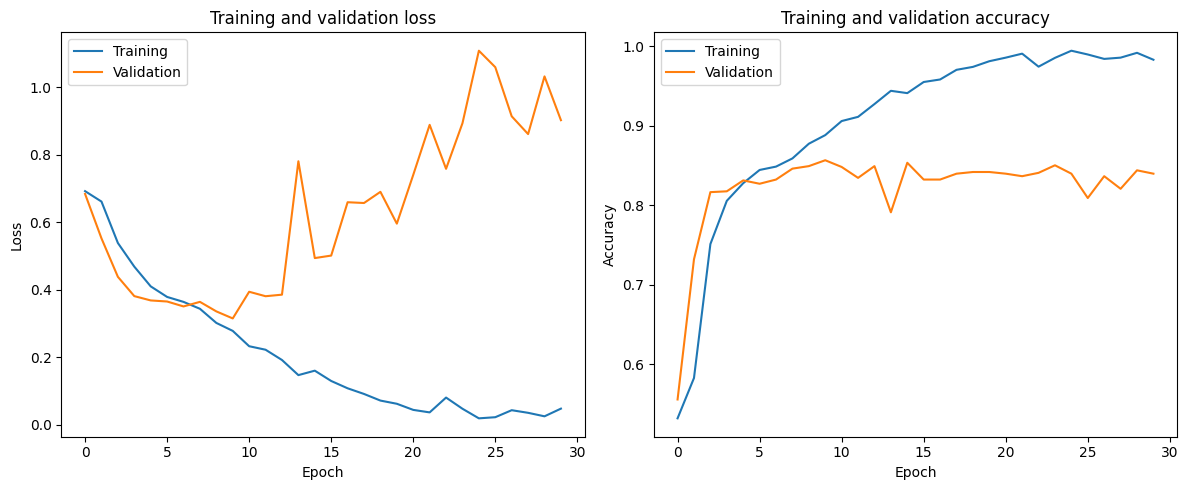

In [ ]:
performance(history_3)

Try to reduce overfitting with BatchNormalization


In [ ]:
model_plus = Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
with tf.device(device_name):
  model_plus.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/30
119/119 [==============================] - 6s 23ms/step - loss: 0.7207 - accuracy: 0.7198 - val_loss: 1.9247 - val_accuracy: 0.5554
Epoch 2/30
119/119 [==============================] - 2s 19ms/step - loss: 0.4516 - accuracy: 0.8001 - val_loss: 2.6701 - val_accuracy: 0.5554
Epoch 3/30
119/119 [==============================] - 3s 22ms/step - loss: 0.4043 - accuracy: 0.8370 - val_loss: 1.6113 - val_accuracy: 0.5554
Epoch 4/30
119/119 [==============================] - 3s 22ms/step - loss: 0.3680 - accuracy: 0.8465 - val_loss: 1.0779 - val_accuracy: 0.6125
Epoch 5/30
119/119 [==============================] - 3s 22ms/step - loss: 0.3421 - accuracy: 0.8582 - val_loss: 0.7751 - val_accuracy: 0.7064
Epoch 6/30
119/119 [==============================] - 2s 21ms/step - loss: 0.2984 - accuracy: 0.8719 - val_loss: 0.5572 - val_accuracy: 0.7635
Epoch 7/30
119/119 [==============================] - 2s 21ms/step - loss: 0.2738 - accuracy: 0.8806 - val_loss: 0.5848 - val_accuracy: 0.7782

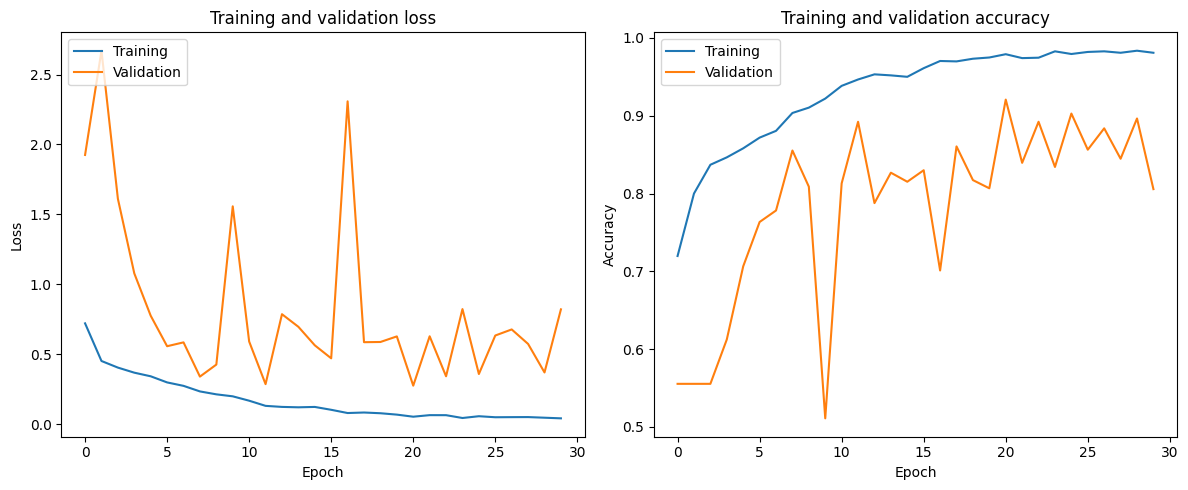

In [ ]:
history_plus = model_plus.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

performance(history_plus)

## Second architecture

In [ ]:
model4 = Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 100, 1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
with tf.device(device_name):
  model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 10, 10, 32)      

In [ ]:
history_4 = model4.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 4s 14ms/step - loss: 0.6938 - accuracy: 0.5333 - val_loss: 0.6954 - val_accuracy: 0.4498
Epoch 2/30
119/119 [==============================] - 1s 9ms/step - loss: 0.6920 - accuracy: 0.5354 - val_loss: 0.6879 - val_accuracy: 0.5533
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.6837 - accuracy: 0.5417 - val_loss: 0.6653 - val_accuracy: 0.5924
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.6007 - accuracy: 0.6793 - val_loss: 0.5317 - val_accuracy: 0.7571
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5291 - accuracy: 0.7565 - val_loss: 0.4829 - val_accuracy: 0.7920
Epoch 6/30
119/119 [==============================] - 1s 9ms/step - loss: 0.4713 - accuracy: 0.7942 - val_loss: 0.4321 - val_accuracy: 0.8173
Epoch 7/30
119/119 [==============================] - 1s 9ms/step - loss: 0.4468 - accuracy: 0.8056 - val_loss: 0.4730 - val_accuracy: 0.7878
Ep

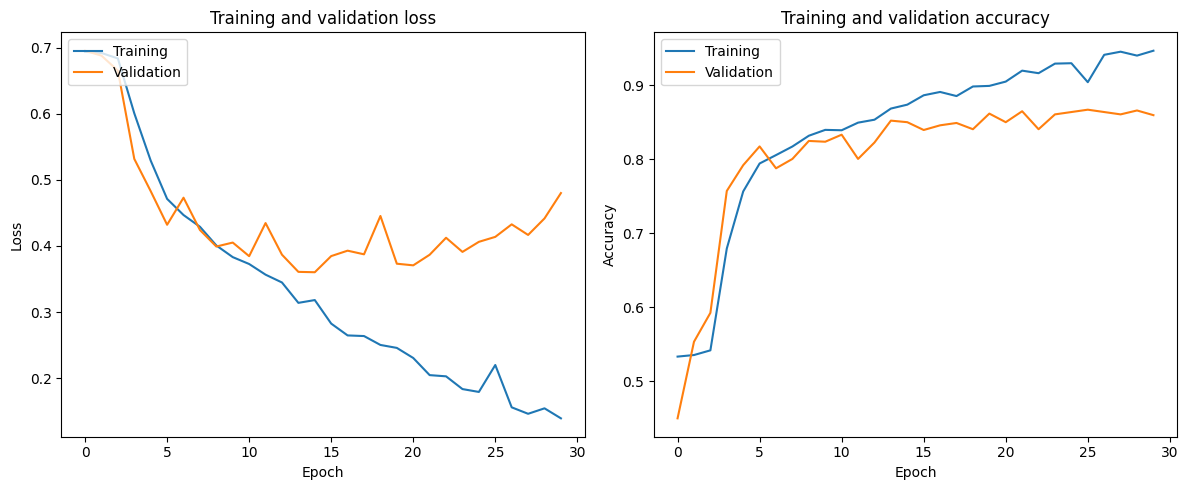

In [ ]:
performance(history_4)

### L2 Regularization

In [ ]:
model5 = second_model()

In [ ]:
with tf.device(device_name):
  model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 32)        0

In [ ]:
history_5 = model5.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels))

Epoch 1/30
119/119 [==============================] - 3s 13ms/step - loss: 0.7239 - accuracy: 0.5481 - val_loss: 0.6706 - val_accuracy: 0.6864
Epoch 2/30
119/119 [==============================] - 1s 10ms/step - loss: 0.6325 - accuracy: 0.6556 - val_loss: 0.5467 - val_accuracy: 0.7614
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5619 - accuracy: 0.7475 - val_loss: 0.5414 - val_accuracy: 0.7561
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5481 - accuracy: 0.7538 - val_loss: 0.5224 - val_accuracy: 0.7687
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5238 - accuracy: 0.7639 - val_loss: 0.5030 - val_accuracy: 0.7592
Epoch 6/30
119/119 [==============================] - 1s 10ms/step - loss: 0.4936 - accuracy: 0.7911 - val_loss: 0.4649 - val_accuracy: 0.8184
Epoch 7/30
119/119 [==============================] - 1s 10ms/step - loss: 0.4737 - accuracy: 0.8030 - val_loss: 0.4856 - val_accuracy: 0.7920

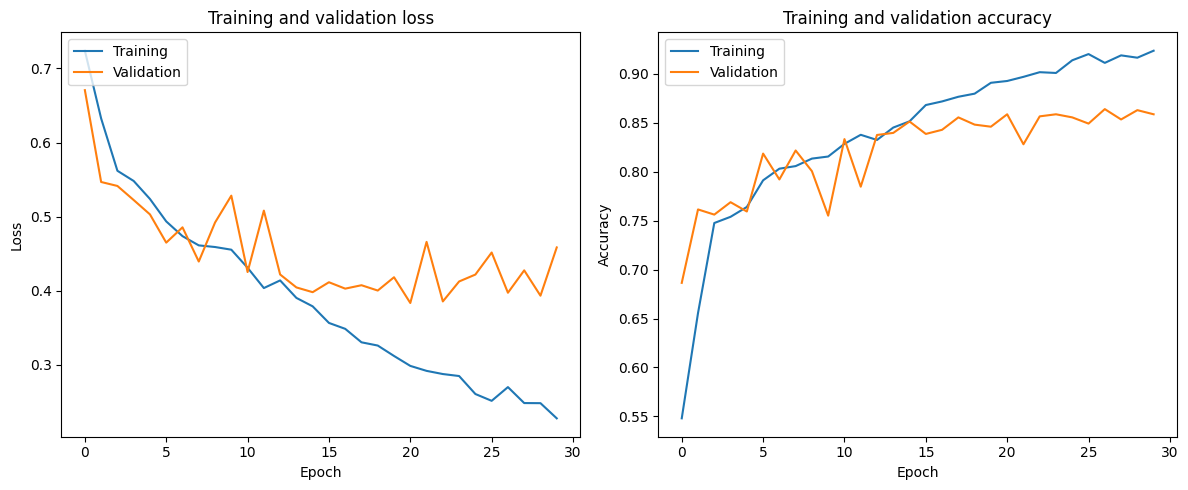

In [ ]:
performance(history_5)

L2 regularization has led to a decrease in both training and validation accuracies. While the training loss has increased, indicating that the model is learning simpler patterns, the validation loss has also decreased slightly, suggesting improved generalization. However, the validation accuracy remains relatively unchanged. It has helped to decrease overfitting but it did not improve much the generalization performance.

In [ ]:
es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True) # it is a classification-based problem so it is better to check val accuracy

In [ ]:
model6 = second_model()
with tf.device(device_name):
  model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_6 = model6.fit(train_images, train_labels, batch_size = batch_size, epochs=30, validation_data = (val_images, val_labels), callbacks = [es])

Epoch 1/30
119/119 [==============================] - 3s 13ms/step - loss: 0.8676 - accuracy: 0.5415 - val_loss: 0.6899 - val_accuracy: 0.6927
Epoch 2/30
119/119 [==============================] - 1s 10ms/step - loss: 0.6555 - accuracy: 0.6373 - val_loss: 0.6275 - val_accuracy: 0.6990
Epoch 3/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5991 - accuracy: 0.7071 - val_loss: 0.5501 - val_accuracy: 0.7529
Epoch 4/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5708 - accuracy: 0.7393 - val_loss: 0.5382 - val_accuracy: 0.7582
Epoch 5/30
119/119 [==============================] - 1s 11ms/step - loss: 0.5434 - accuracy: 0.7678 - val_loss: 0.4881 - val_accuracy: 0.8141
Epoch 6/30
119/119 [==============================] - 1s 10ms/step - loss: 0.5163 - accuracy: 0.7905 - val_loss: 0.4671 - val_accuracy: 0.8215
Epoch 7/30
119/119 [==============================] - 1s 9ms/step - loss: 0.5049 - accuracy: 0.8030 - val_loss: 0.4502 - val_accuracy: 0.8342


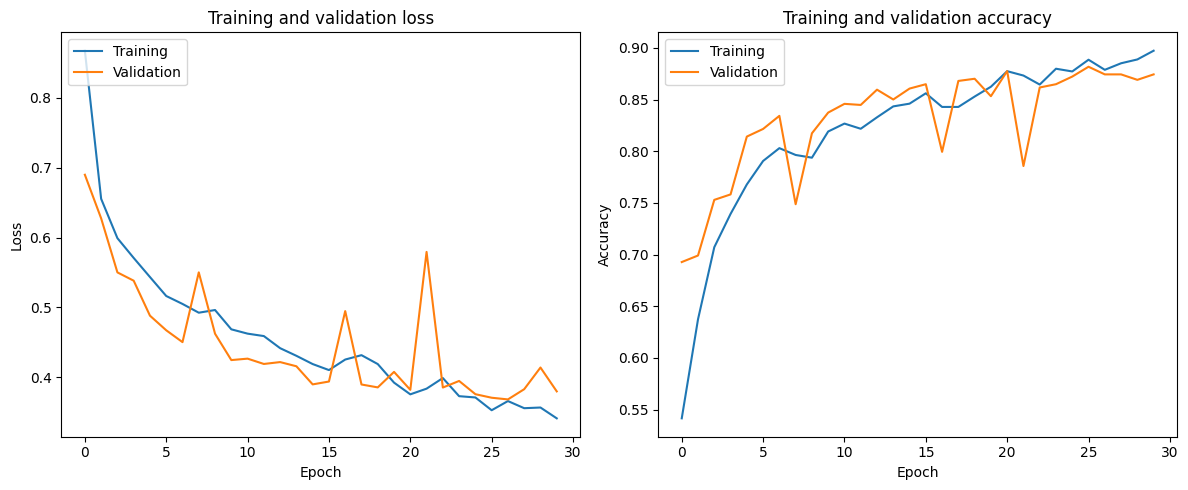

In [ ]:
performance(history_6)

### Increase number of epochs

In [ ]:
model7 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

with tf.device(device_name):
  model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_7 = model7.fit(train_images, train_labels, batch_size = batch_size, epochs=50, validation_data = (val_images, val_labels), callbacks = [es])

Epoch 1/50
119/119 [==============================] - 4s 16ms/step - loss: 0.8695 - accuracy: 0.5452 - val_loss: 0.6354 - val_accuracy: 0.7086
Epoch 2/50
119/119 [==============================] - 2s 13ms/step - loss: 0.6523 - accuracy: 0.6484 - val_loss: 0.5347 - val_accuracy: 0.7687
Epoch 3/50
119/119 [==============================] - 2s 17ms/step - loss: 0.5767 - accuracy: 0.7327 - val_loss: 0.5221 - val_accuracy: 0.7751
Epoch 4/50
119/119 [==============================] - 2s 18ms/step - loss: 0.5653 - accuracy: 0.7480 - val_loss: 0.5138 - val_accuracy: 0.7962
Epoch 5/50
119/119 [==============================] - 2s 14ms/step - loss: 0.5390 - accuracy: 0.7620 - val_loss: 0.4869 - val_accuracy: 0.7994
Epoch 6/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5405 - accuracy: 0.7689 - val_loss: 0.4787 - val_accuracy: 0.8247
Epoch 7/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5102 - accuracy: 0.7816 - val_loss: 0.4605 - val_accuracy: 0.8226

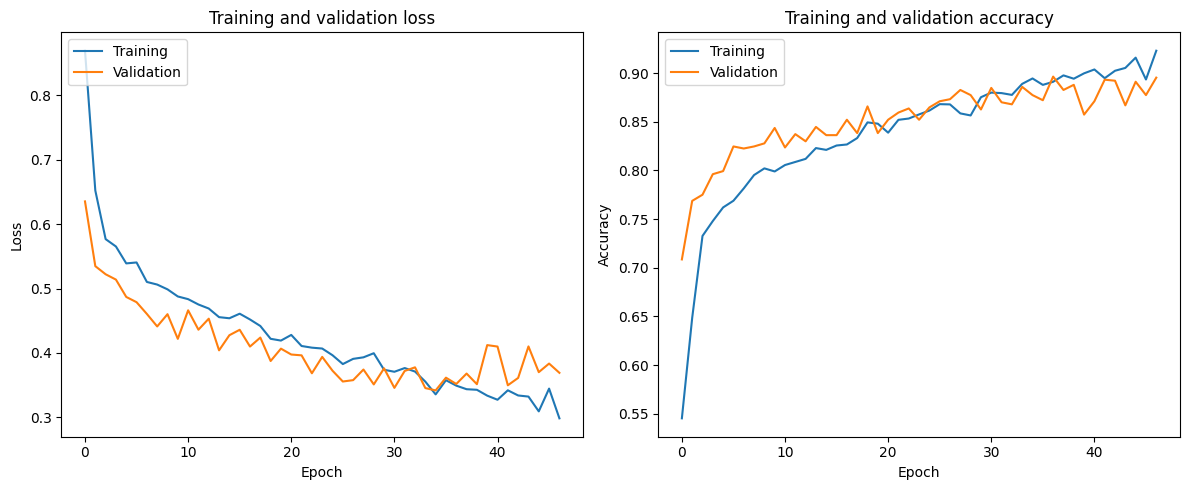

In [ ]:
performance(history_7)

### Add padding and increase neurons in Dense layer

In [ ]:
model8 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

with tf.device(device_name):
    model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/50
119/119 [==============================] - 9s 28ms/step - loss: 1.0030 - accuracy: 0.5304 - val_loss: 0.7017 - val_accuracy: 0.5554
Epoch 2/50
119/119 [==============================] - 2s 16ms/step - loss: 0.6976 - accuracy: 0.5365 - val_loss: 0.6946 - val_accuracy: 0.5554
Epoch 3/50
119/119 [==============================] - 2s 18ms/step - loss: 0.6688 - accuracy: 0.6083 - val_loss: 0.6083 - val_accuracy: 0.7476
Epoch 4/50
119/119 [==============================] - 2s 17ms/step - loss: 0.5959 - accuracy: 0.7137 - val_loss: 0.5920 - val_accuracy: 0.7381
Epoch 5/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5672 - accuracy: 0.7446 - val_loss: 0.5018 - val_accuracy: 0.8015
Epoch 6/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5645 - accuracy: 0.7422 - val_loss: 0.5065 - val_accuracy: 0.7899
Epoch 7/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5329 - accuracy: 0.7660 - val_loss: 0.5278 - val_accuracy: 0.7550

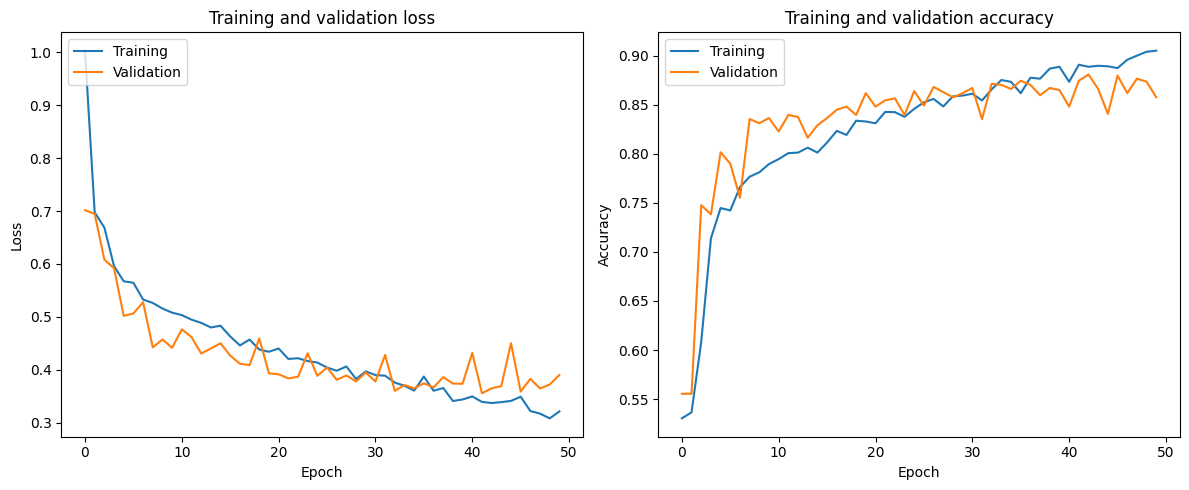

In [ ]:
history_8 = model8.fit(train_images, train_labels, batch_size = batch_size, epochs=50, validation_data = (val_images, val_labels), callbacks = [es])
performance(history_8)

## Third architecture

Epoch 1/30
119/119 [==============================] - 8s 26ms/step - loss: 0.9788 - accuracy: 0.5079 - val_loss: 0.7944 - val_accuracy: 0.4446
Epoch 2/30
119/119 [==============================] - 2s 20ms/step - loss: 0.8530 - accuracy: 0.5573 - val_loss: 0.8484 - val_accuracy: 0.4446
Epoch 3/30
119/119 [==============================] - 2s 15ms/step - loss: 0.7485 - accuracy: 0.6381 - val_loss: 0.9133 - val_accuracy: 0.4446
Epoch 4/30
119/119 [==============================] - 2s 15ms/step - loss: 0.6755 - accuracy: 0.7034 - val_loss: 0.8732 - val_accuracy: 0.4530
Epoch 5/30
119/119 [==============================] - 2s 15ms/step - loss: 0.6278 - accuracy: 0.7319 - val_loss: 0.6770 - val_accuracy: 0.6589
Epoch 6/30
119/119 [==============================] - 2s 15ms/step - loss: 0.5975 - accuracy: 0.7681 - val_loss: 0.5818 - val_accuracy: 0.7772
Epoch 7/30
119/119 [==============================] - 2s 15ms/step - loss: 0.5740 - accuracy: 0.7795 - val_loss: 0.5139 - val_accuracy: 0.8120

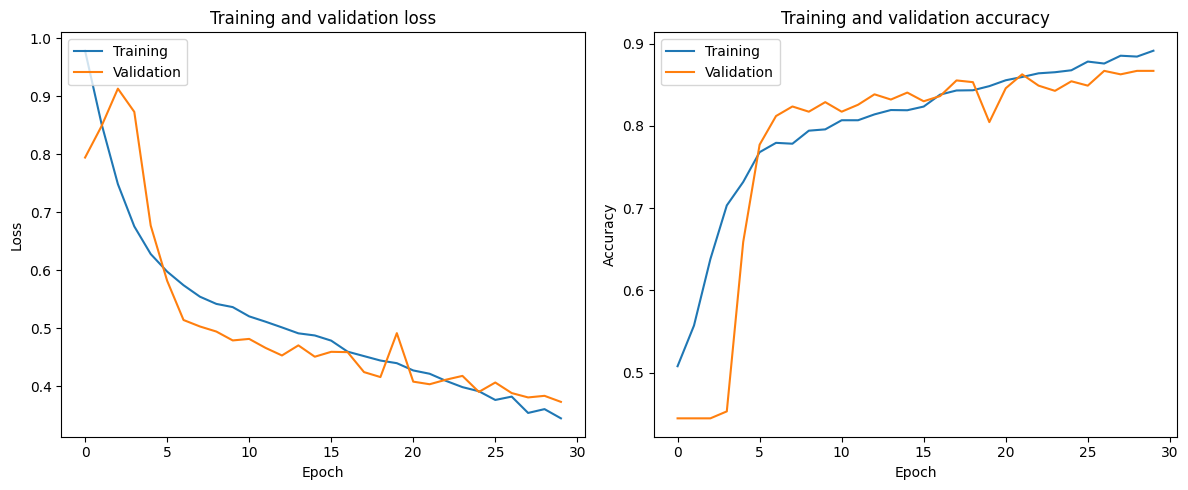

In [ ]:
with tf.device(device_name):

   model9 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
   model9.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])
   history_9 = model9.fit(train_images, train_labels, epochs=30, validation_data = (val_images, val_labels), callbacks=[es])

performance(history_9)

Adding more regularization and training for more epochs

Epoch 1/50
119/119 [==============================] - 17s 25ms/step - loss: 1.5461 - accuracy: 0.5774 - val_loss: 1.4988 - val_accuracy: 0.4446
Epoch 2/50
119/119 [==============================] - 2s 15ms/step - loss: 1.4029 - accuracy: 0.6535 - val_loss: 1.4611 - val_accuracy: 0.4446
Epoch 3/50
119/119 [==============================] - 2s 15ms/step - loss: 1.2872 - accuracy: 0.7298 - val_loss: 1.4158 - val_accuracy: 0.4794
Epoch 4/50
119/119 [==============================] - 2s 15ms/step - loss: 1.2089 - accuracy: 0.7594 - val_loss: 1.3381 - val_accuracy: 0.5523
Epoch 5/50
119/119 [==============================] - 2s 16ms/step - loss: 1.1391 - accuracy: 0.7921 - val_loss: 1.2178 - val_accuracy: 0.7043
Epoch 6/50
119/119 [==============================] - 2s 20ms/step - loss: 1.0864 - accuracy: 0.8053 - val_loss: 1.1111 - val_accuracy: 0.7899
Epoch 7/50
119/119 [==============================] - 2s 18ms/step - loss: 1.0237 - accuracy: 0.8222 - val_loss: 0.9779 - val_accuracy: 0.850

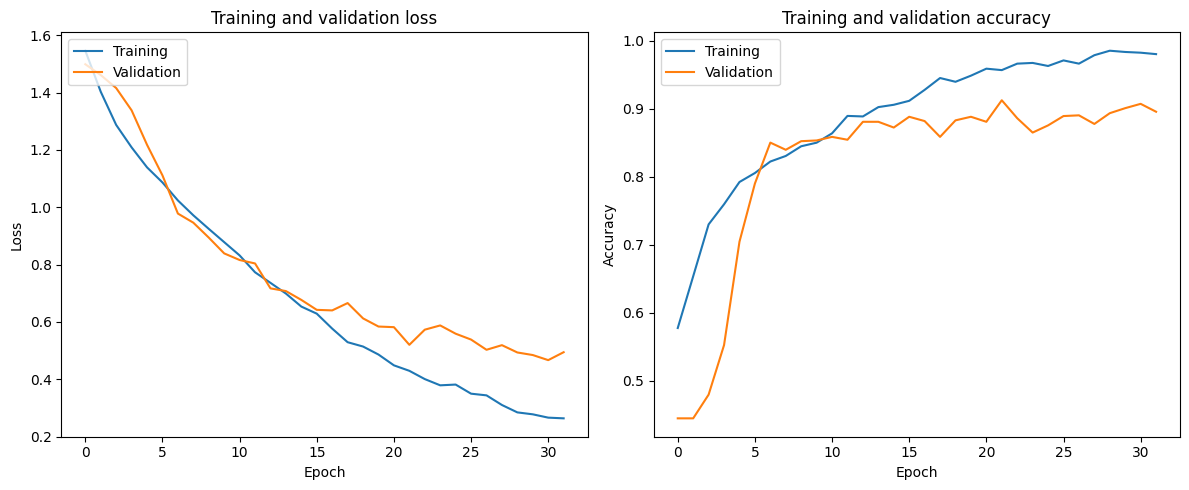

In [ ]:
with tf.device(device_name):

   model10 = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
   model10.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.0001),metrics=['accuracy'])
   history_10 = model10.fit(train_images, train_labels, epochs=50, validation_data = (val_images, val_labels), callbacks=[es])

performance(history_10)

## Hyperparameter tuning

### Optimization of the convolutional layers nodes

In [ ]:
layer_nodes = [128, 64, 32]

best_accuracy = 0
best_params = {}

with tf.device(device_name):
    for l1 in layer_nodes:
        for l2 in layer_nodes:
          for l3 in layer_nodes:
            model = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

            val_accuracy = history.history['val_accuracy'][-1]

            print(f'Layer Sizes: {l1}, {l2}, {l3}, Validation Accuracy: {val_accuracy}')

            # Update best parameters if this configuration has higher validation accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'layer1_size': l1, 'layer2_size': l2, 'layer3_size': l3}

print(f'Best parameters: {best_params}, Best validation accuracy: {best_accuracy}')

Layer Sizes: 128, 128, 128, Validation Accuracy: 0.8753960132598877
Layer Sizes: 128, 128, 64, Validation Accuracy: 0.5966209173202515
Layer Sizes: 128, 128, 32, Validation Accuracy: 0.8616684079170227
Layer Sizes: 128, 64, 128, Validation Accuracy: 0.840549111366272
Layer Sizes: 128, 64, 64, Validation Accuracy: 0.7940865755081177
Layer Sizes: 128, 64, 32, Validation Accuracy: 0.7909187078475952
Layer Sizes: 128, 32, 128, Validation Accuracy: 0.6705385446548462
Layer Sizes: 128, 32, 64, Validation Accuracy: 0.8352692723274231
Layer Sizes: 128, 32, 32, Validation Accuracy: 0.7687433958053589
Layer Sizes: 64, 128, 128, Validation Accuracy: 0.8975712656974792
Layer Sizes: 64, 128, 64, Validation Accuracy: 0.8500527739524841
Layer Sizes: 64, 128, 32, Validation Accuracy: 0.8458289504051208
Layer Sizes: 64, 64, 128, Validation Accuracy: 0.5934529900550842
Layer Sizes: 64, 64, 64, Validation Accuracy: 0.8848996758460999
Layer Sizes: 64, 64, 32, Validation Accuracy: 0.7539598941802979
Layer 

### Optimization of Learning Rate

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
best_accuracy = 0
best_learning_rate = None


for lr in learning_rates:
    model = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

    val_accuracy = history.history['val_accuracy'][-1]

    print(f'Learning Rate: {lr}, Validation Accuracy: {val_accuracy}')

    # Update best learning rate if this one has higher validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_learning_rate = lr

print(f'Best learning rate: {best_learning_rate}, Best validation accuracy: {best_accuracy}')


Learning Rate: 0.01, Validation Accuracy: 0.8574445843696594
Learning Rate: 0.001, Validation Accuracy: 0.9144667387008667
Learning Rate: 0.0001, Validation Accuracy: 0.8658922910690308
Best learning rate: 0.001, Best validation accuracy: 0.9144667387008667


### Optimizaion of pools and kernels sizes

In [ ]:
pool_sizes = [2, 3, 4]
kernel_sizes = [(3, 3), (5, 5)]

best_accuracy = 0
best_params = {}

with tf.device(device_name):
        for pool_size in pool_sizes:
            for kernel_size in kernel_sizes:
                model = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

                history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), verbose=0)

                val_accuracy = history.history['val_accuracy'][-1]

                print(f'Pool Size: {pool_size}, Kernel Size: {kernel_size}, Validation Accuracy: {val_accuracy}')

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'pool_size': pool_size, 'kernel_size': kernel_size}

print(f'Best parameters: {best_params}, Best validation accuracy: {best_accuracy}')

Pool Size: 2, Kernel Size: (3, 3), Validation Accuracy: 0.8785638809204102
Pool Size: 2, Kernel Size: (5, 5), Validation Accuracy: 0.8342133164405823
Pool Size: 3, Kernel Size: (3, 3), Validation Accuracy: 0.8701161742210388
Pool Size: 3, Kernel Size: (5, 5), Validation Accuracy: 0.8394931554794312
Pool Size: 4, Kernel Size: (3, 3), Validation Accuracy: 0.9049630165100098
Pool Size: 4, Kernel Size: (5, 5), Validation Accuracy: 0.8965153098106384
Best parameters: {'pool_size': 4, 'kernel_size': (3, 3)}, Best validation accuracy: 0.9049630165100098


##### Final Model

Epoch 1/50
119/119 [==============================] - 6s 16ms/step - loss: 1.5679 - accuracy: 0.7187 - val_loss: 1.4748 - val_accuracy: 0.5512
Epoch 2/50
119/119 [==============================] - 2s 13ms/step - loss: 1.0717 - accuracy: 0.8080 - val_loss: 1.2617 - val_accuracy: 0.5554
Epoch 3/50
119/119 [==============================] - 2s 13ms/step - loss: 0.7947 - accuracy: 0.8347 - val_loss: 0.8994 - val_accuracy: 0.7128
Epoch 4/50
119/119 [==============================] - 2s 13ms/step - loss: 0.6200 - accuracy: 0.8500 - val_loss: 0.6282 - val_accuracy: 0.8353
Epoch 5/50
119/119 [==============================] - 2s 13ms/step - loss: 0.5155 - accuracy: 0.8629 - val_loss: 0.6394 - val_accuracy: 0.7656
Epoch 6/50
119/119 [==============================] - 1s 13ms/step - loss: 0.4438 - accuracy: 0.8772 - val_loss: 0.4374 - val_accuracy: 0.8659
Epoch 7/50
119/119 [==============================] - 2s 15ms/step - loss: 0.3761 - accuracy: 0.8883 - val_loss: 0.3909 - val_accuracy: 0.8722

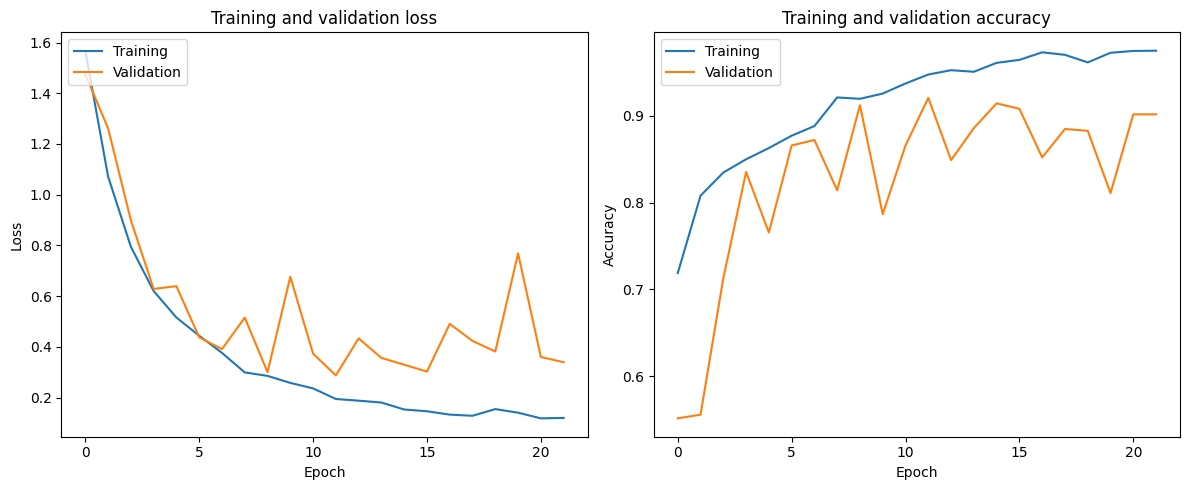

In [ ]:
with tf.device(device_name):

   model_final = Sequential([
    InputLayer(input_shape=(100,100,1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.7),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
   model_final.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.001),metrics=['accuracy'])
   history_final = model_final.fit(train_images, train_labels, epochs=50, validation_data = (val_images, val_labels), callbacks=[es])

performance(history_final)

### Keras tuner

In [ ]:
def model_active(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(100,100,1)))
  active_hp = hp.Choice('activation', values = ['relu'])
  hp_lr = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 1e-5])
  dropout_layer = hp.Float("dropout_layer", min_value = 0.2, max_value = 0.7, step = 0.1)

  # First block
  model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_1", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

    # Second block
  model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_2", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
  model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

  # Third block
 # model.add(tf.keras.layers.Conv2D(filters = hp.Int("conv_3", min_value = 32, max_value = 256, step = 16), kernel_size = 3, activation = active_hp))
 # model.add(tf.keras.layers.MaxPooling2D(pool_size = 2))

  model.add(tf.keras.layers.Flatten())

  #model.add(tf.keras.layers.Dense(units = hp.Choice("neurons", values=[16, 32, 64]), activation = active_hp))
  #model.add(tf.keras.layers.Dropout(dropout_layer))

  model.add(tf.keras.layers.Dense(units = hp.Choice("neurons", values=[16, 32, 64]), activation = active_hp))
  model.add(tf.keras.layers.Dropout(dropout_layer))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.BayesianOptimization(model_active,
                     objective='val_accuracy',
                     max_trials=10,
                     directory="/content",
                     project_name="first")

In [ ]:
se = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
tuner.search(train_images, train_labels, batch_size = 32, epochs=50, validation_data = (val_images, val_labels), callbacks = [se])

Trial 10 Complete [00h 03m 09s]
val_accuracy: 0.8384371995925903

Best val_accuracy So Far: 0.869060218334198
Total elapsed time: 00h 15m 31s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hyperparameters.values

{'activation': 'relu',
 'learning_rate': 0.0001,
 'dropout_layer': 0.4,
 'conv_1': 112,
 'conv_2': 176,
 'neurons': 64}

In [ ]:
final_model = tuner.hypermodel.build(best_hyperparameters)

best_history = final_model.fit(train_images, train_labels, epochs = 50, batch_size = batch_size, validation_data = (val_images, val_labels), callbacks = [se])

Epoch 1/50
119/119 [==============================] - 5s 31ms/step - loss: 0.6422 - accuracy: 0.6104 - val_loss: 0.5428 - val_accuracy: 0.7624
Epoch 2/50
119/119 [==============================] - 3s 28ms/step - loss: 0.5478 - accuracy: 0.7224 - val_loss: 0.4790 - val_accuracy: 0.8015
Epoch 3/50
119/119 [==============================] - 3s 29ms/step - loss: 0.5009 - accuracy: 0.7591 - val_loss: 0.4931 - val_accuracy: 0.7592
Epoch 4/50
119/119 [==============================] - 4s 30ms/step - loss: 0.4913 - accuracy: 0.7760 - val_loss: 0.4333 - val_accuracy: 0.8110
Epoch 5/50
119/119 [==============================] - 3s 29ms/step - loss: 0.4795 - accuracy: 0.7800 - val_loss: 0.4478 - val_accuracy: 0.7994
Epoch 6/50
119/119 [==============================] - 3s 29ms/step - loss: 0.4467 - accuracy: 0.8043 - val_loss: 0.4107 - val_accuracy: 0.8152
Epoch 7/50
119/119 [==============================] - 4s 30ms/step - loss: 0.4330 - accuracy: 0.8106 - val_loss: 0.3976 - val_accuracy: 0.8237

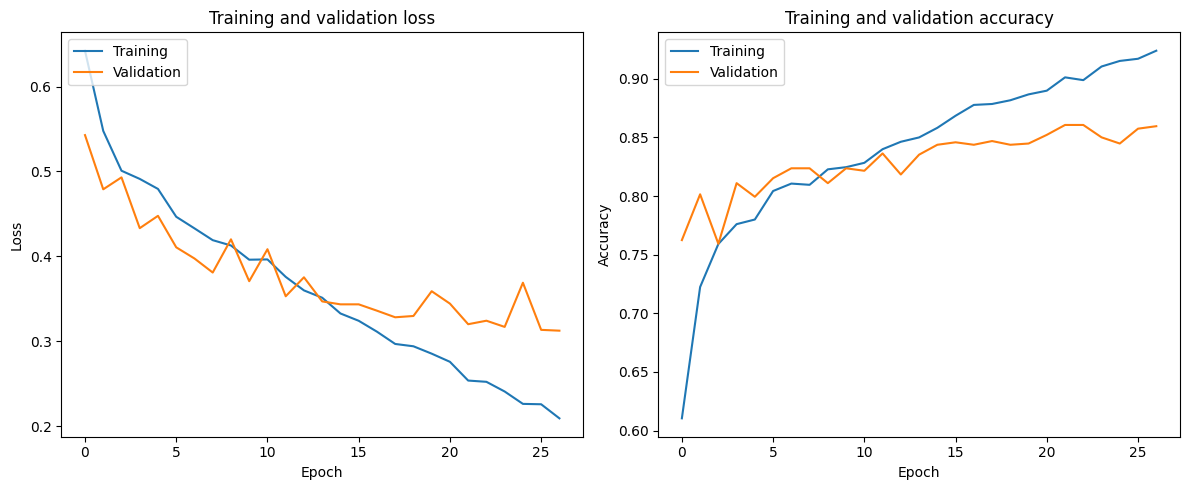

In [ ]:
performance(best_history)

# Evaluation

In [ ]:
test_images = test_images / 255.0

In [ ]:
model_final.evaluate(test_images, test_labels)

37/37 [==============================] - 0s 5ms/step - loss: 0.3656 - accuracy: 0.8868


[0.3656403720378876, 0.8868243098258972]

88% of accuracy on the test set

In [ ]:
predictions = model_final.predict(test_images)

37/37 [==============================] - 0s 4ms/step


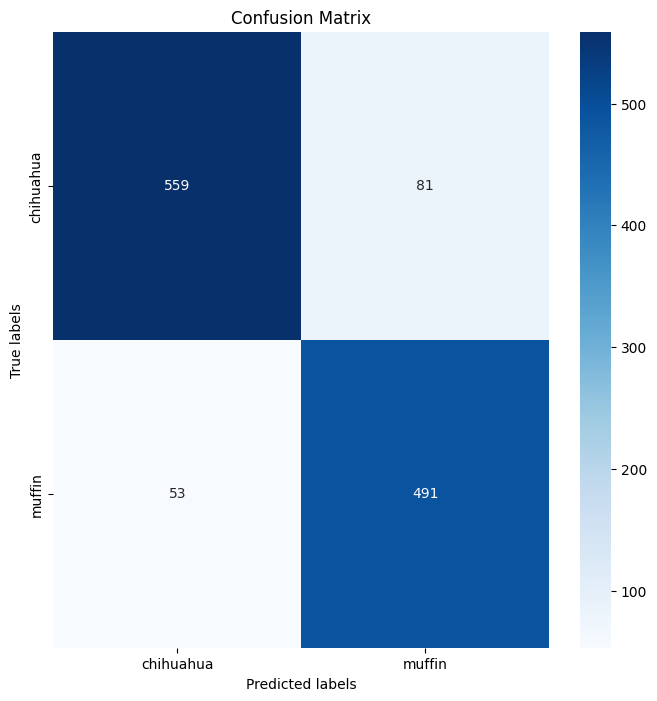

In [ ]:
predicted = np.round(predictions).astype(int)
matrix = confusion_matrix(test_labels,predicted)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['chihuahua', 'muffin'], yticklabels=['chihuahua', 'muffin'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

Let us test it on a picture from a friend!

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cane.jpeg to cane.jpeg


In [ ]:
from PIL import Image
import io

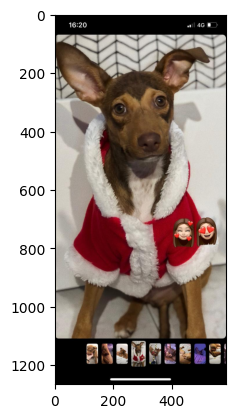

In [ ]:
uploaded_image_bytes = uploaded['cane.jpeg']
img = Image.open(io.BytesIO(uploaded_image_bytes))
plt.imshow(img)

In [ ]:
resize = tf.image.resize(img, (100, 100))

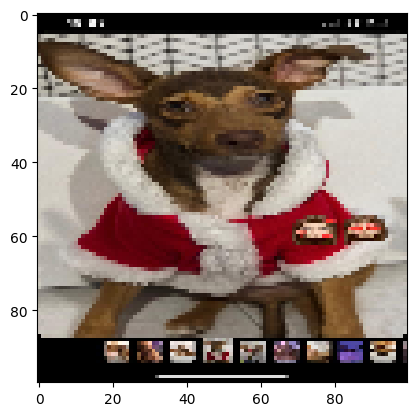

In [ ]:
plt.imshow(resize.numpy().astype(int))

In [ ]:
gray_img = tf.image.rgb_to_grayscale(resize)

In [ ]:
expe = model_final.predict(np.expand_dims(gray_img/255, 0))

1/1 [==============================] - 0s 483ms/step


In [ ]:
expe

array([[9.0094414e-07]], dtype=float32)

The value is really close to 0 which in our case represents Chihuahuas proving that the model worked!